*Implementation of BGP with a recursive OM algorithm.*

### Extracted Story
Several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. Each general observes the enemy and communicates his observation to the others. Each general then combines all the reported observations into a single plan of action (i.e., “attack” or “retreat”), for example, by using a majority vote. Communicating only by messengers, the generals must agree upon a common, and reasonable battle plan, however, one or more of them may be traitors who will try to confuse the others. All loyal generals must carry out the same plan, whereas the traitors may do anything they wish.

### Extracted Story (verbatim)
We imagine that several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. The generals can communicate with one another only by messenger. After observing the enemy, they must decide upon a common plan of action. However, some of the generals may be traitors, trying to prevent the loyal generals from reaching agreement.
...
All loyal generals decide upon the same plan of action... but the traitors may do anything they wish.
...
They loyal generals should not only reach agreement, but should agree upon a reasonable plan.

*Everything below this point is based on the verbatim version of the story.*

### User Stories
* As a GENERAL I want to...
  * make observations on an enemy city to decide upon a plan of action.
  * be able to communicate with other genrals to share our observations.
* As a LOYAL GENERAL I want to...
  * decide upon a reasonable plan of action so that my division does what is best.
  * decide upon the same plan of action as all other loyal generals so order within the army is maintained.
* As a DISLOYAL GENERAL I want to...
  * make false or contradicting observations to prevent the loyal generals from reaching agreement.
* As a MESSENGER I want to...
  * deliver messages between generals/divisons so they can reach upon some agreement.

### Design Decisions
* Recusive OM algorithm.
* Loyal generals return the order that the last commander made.
* Traitors return random orders.


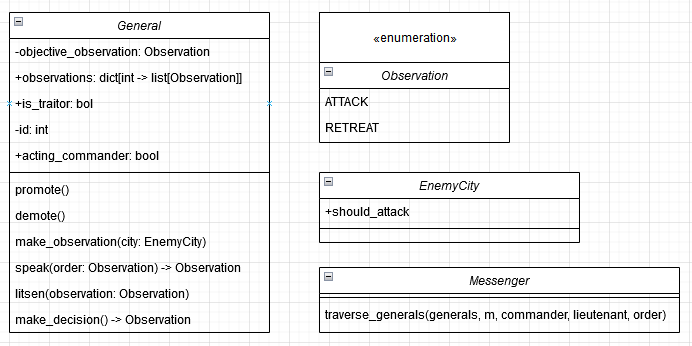


### Comments

This implementation was surprisingly more difficult than expected... In the BGP paper, for example, there is some difference between fig 3. and fig 4. (page 8) when lietuenants exchange message desipte both representing the OM(1) step of the algorithm. Likewise, there is *some* contradiction with regards to how *exactly* the algorithm works in various online sources.

#### Comparison With The JVerewolf Solution

The solution presented here is fundamentally different due to the fact that an effort was made to make use of the `Messenger` class. This, I believe, is an inferior design to that of JVerewolf, albeit, more accurate to the story. For the recurive algorithm itself, various designs were tested with the initial implementation being as follows:

```
for g in generals:
    if not g.acting_commander:
        g.listen(commander._id, commander.speak())
            
    if m > 0:
        for g in generals:
            if not g.acting_commander:
                g.promote()
                Messenger.traverse_generals(g.speak(order), generals, m-1, g)
                g.demote()
```

The final design which was settled for is one that is of a quite similar structure to that of JVerewolf's solution. With that said, the results of our solution do not match those of JVerewolf's exactly. Likewise, this solution fails to prove the claim that 3m+1 generals solves the BGP. Various tests revealed that this problem also existed in JVerewolf's code by simply modifying the behaviour of the traitors (ie. adding randomness).

It is true, indeed, that with 3m+1 generals, the odds of disagreement go down, however it is still possible.

In [1069]:
import random
import logging
from enum import Enum, auto
from itertools import combinations
from collections import Counter, defaultdict

In [1070]:
logging.basicConfig(level=100, force=True)

In [1071]:
class Observation(Enum):
    '''
    Represents an observation that a general has made on a particular city.
    '''
    ATTACK = auto()
    RETREAT = auto()

In [1072]:
class EnemyCity:
    def __init__(self, should_attack):
        # A city is modelled to be "objectively" either attackable or not
        self.should_attack = should_attack

In [1073]:
class General:
    '''
    Represents a General who is either loyal or a traitor.
    '''
    # Used for easier representation
    next_id = 0

    def __init__(self, is_traitor=False):
        self._objective_observation = None
        self.observations = defaultdict(list)
        self.is_traitor = is_traitor

        self._id = General.next_id
        General.next_id += 1
        
        self.acting_commander = False
    
    def promote(self): self.acting_commander = True 
    def demote(self): self.acting_commander = False 
    
    def make_observation(self, city: EnemyCity):
        self._objective_observation = (Observation.RETREAT, Observation.ATTACK)[city.should_attack]
    
    def speak(self, order=None):
        if not self.is_traitor:
            if order is not None:
                return order
            else:
                return self._objective_observation

        return random.choice([Observation.RETREAT, Observation.ATTACK])
    
    def listen(self, gid, observation):
        self.observations[gid].append(observation)
    
    def make_decision(self):
        decisions = []
        
        for o in self.observations:
            decisions.append(Counter(self.observations[o]).most_common(1)[0][0])
            
        return Counter(decisions).most_common()
    
    def __repr__(self) -> str:
        return f'<General {self._id} [{"t" if self.is_traitor else "l"}]>'

In [1074]:
class Messenger:
        @staticmethod
        def traverse_generals(generals, m, *, commander=None, lieutenant=None, order=None):
            if commander is None:
                commander = generals[0]
                commander.promote()
            
            if m < 0:
                if commander is not lieutenant:
                    lieutenant.listen(commander._id, order)
            elif m == 0:
                for g in generals:
                    Messenger.traverse_generals(
                        generals, m-1, commander=commander, lieutenant=g, order=commander.speak(order)
                    )
            else:
                for g in generals:
                    if g is not lieutenant and not g.acting_commander:
                        g.promote()
                        
                        Messenger.traverse_generals(
                            generals, m-1, commander=g, lieutenant=None, order=g.speak(order)
                        )
                        
                        g.demote()

In [1075]:
def main(total_generals, num_traitors=-1, should_attack=None):
    '''
    Run the main simulation between a number of generals.

    :param total_generals: The TOTAL number of generals
    :param num_traitors: The number of traitors.
        Can be expressed either as...
            int >= 0                 for an absolute size
            float >= 0.0 and <= 1.0  for a percentage of `total_generals`
            int < 0                  for random distribution
    :param should_attack: Should the city be objectively attackable or not.
        (default: random)
    :return: The PoA agreed to by the loyal generals.
        ("retreat", "attack" or None)
    '''
    n_traitors = 0
    
    if isinstance(num_traitors, int):
        if num_traitors >= 0:
            n_traitors = num_traitors
        else:
            n_traitors = int(total_generals * random.random())
    elif isinstance(num_traitors, float) and 0 <= num_traitors <= 1:
        n_traitors = int(total_generals * num_traitors)
    
    generals = [General(False) for _ in range(total_generals - n_traitors)] + \
               [General(True) for _ in range(n_traitors)]
    
    if should_attack is not None:
        city = EnemyCity(should_attack)
    else:
        city = EnemyCity(random.choice([True, False]))
    
    logging.info(
        f'Running with {total_generals} total generals of which'
        f' {n_traitors} are traitorous. EnemyCity.should_attack == {city.should_attack}\n'
    )
    
    # Each general makes an objective observation
    for g in generals:
        g.make_observation(city)
    
    # Each general communicates his observation (or not)
    m = Messenger()
    m.traverse_generals(generals, n_traitors)
    
    # Each general comes up with a plan of action
    loyal_poa, agreed_plan = set(), None
    
    for g in generals:
        if g.acting_commander:
            continue
            
        decision = g.make_decision()[0][0]
        
        if not g.is_traitor:
            loyal_poa.add(decision)
    
    if len(loyal_poa) != 1:
        logging.info('Loyal Generals cannot agree on a plan of action!!!\n')
    else:
        agreed_plan = loyal_poa.pop()
        logging.info(f'Loyal Generals have agreed on: {agreed_plan}\n')
    
    total_a, total_r = 0, 0

    for g in generals:
        a, r = 0, 0
        
        for gid in g.observations:
            for msg in g.observations[gid]:
                if msg is Observation.ATTACK:
                    a += 1
                else:
                    r += 1
        
        total_a += a
        total_r += r

        logging.debug(
            f'{"[!] " if g.is_traitor else ""}'
            f'General {g._id} has made the objective observation of {g._objective_observation.name}'
            f' and reported ATTTACK {a} times and RETREAT {r} times'
        )
    
    return generals, agreed_plan, total_a, total_r

In [1076]:
def test_runner(test_cases, test_runs):
    """
    A simple test runner for this implementation of the BGP.
    
    :param test_cases: a list of tuples specifying what
        tests should be run in the format [(num_generals, num_traitors), ...]
    :param test_runs: the number of times that each test should be run
    """
    # [(num_generals, num_traitors), ...]
    for test in test_cases:
        print(f'\n\nRunning test {test}\n{"-"*20}')

        for _ in range(test_runs):
            generals, plan, a, r = main(*test, True)
            print(f'\n[PLAN={plan} ATTACK={a} RETREAT={r}]\n')

            for general in generals:
                observations = [0, 0]  # attack, retreat

#                 for observation in general.last_observations:
#                     if observation is Observation.ATTACK:
#                         observations[0] += 1
#                     else:
#                         observations[1] += 1
                
#                 print(f'{general}: attack={observations[0]} retreat={observations[1]}')
                print(f'{general}: {general.make_decision()}, {len(general.observations)}')

In [1101]:
if __name__ == '__main__':
    # m = 10  # 10 traitors
    
    # # The loyal generals should all agree to the same reasonable plan
    # main((3 * m) + 1, m)
    
    # # Here, the loyal generals *should* fail to 
    # # reach agreement or agree to an "unreasonable" plan.
    # # (This doesn't actually happen...)
    # main((3 * m), m)  # Note the missing `+1`
    
    # main(15, 10)

    tests = [
        (10, 3),
        (9, 3)
    ]

    test_runner(tests, 1)



Running test (10, 3)
--------------------

[PLAN=Observation.ATTACK ATTACK=2744 RETREAT=1792]

<General 438 [l]>: [(<Observation.ATTACK: 1>, 8), (<Observation.RETREAT: 2>, 1)], 9
<General 439 [l]>: [(<Observation.ATTACK: 1>, 7), (<Observation.RETREAT: 2>, 1)], 8
<General 440 [l]>: [(<Observation.ATTACK: 1>, 6), (<Observation.RETREAT: 2>, 2)], 8
<General 441 [l]>: [(<Observation.ATTACK: 1>, 6), (<Observation.RETREAT: 2>, 2)], 8
<General 442 [l]>: [(<Observation.ATTACK: 1>, 7), (<Observation.RETREAT: 2>, 1)], 8
<General 443 [l]>: [(<Observation.ATTACK: 1>, 5), (<Observation.RETREAT: 2>, 3)], 8
<General 444 [l]>: [(<Observation.ATTACK: 1>, 8)], 8
<General 445 [t]>: [(<Observation.ATTACK: 1>, 8)], 8
<General 446 [t]>: [(<Observation.ATTACK: 1>, 7), (<Observation.RETREAT: 2>, 1)], 8
<General 447 [t]>: [(<Observation.ATTACK: 1>, 8)], 8


Running test (9, 3)
--------------------

[PLAN=Observation.RETREAT ATTACK=1260 RETREAT=1428]

<General 448 [l]>: [(<Observation.RETREAT: 2>, 7), (<Observ